In [32]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np

import matplotlib.pyplot as plt
from collections import defaultdict


In [33]:
batch_size = 128
random_seed = 42
dataset_path = 'data/Animals-10/raw-img'
translate = {"cane": "dog", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo", "ragno": "spider"}

def translate_class(class_name):
    return translate[class_name] if class_name in translate else class_name


In [34]:
# perform data augmentation on the training data
transform_train_data = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test_data = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Because images were not the same size, the image sizes were normalised.
The training data was augmented with random horizontal flips, rotations, and color changing.

In [35]:
full_dataset = datasets.ImageFolder(root=dataset_path)
print(f'Classes: {full_dataset.classes}')
print('Size of full dataset:', len(full_dataset))


Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Size of full dataset: 26164


In [36]:
# split the dataset into train and test sets
train_size = int(0.7 * len(full_dataset))  # 70% for training
val_size = int(0.1 * len(full_dataset))  # 10% for validation
test_size = len(full_dataset) - train_size - val_size

print(f'Train size: {train_size}, Val size: {val_size},  Test size: {test_size}')

Train size: 18314, Val size: 2616,  Test size: 5234


In [37]:
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

train_ds = Subset(datasets.ImageFolder(root=dataset_path, transform=transform_train_data), train_dataset.indices)
val_ds = Subset(datasets.ImageFolder(root=dataset_path, transform=transform_train_data), val_dataset.indices)
test_ds = Subset(datasets.ImageFolder(root=dataset_path, transform=transform_test_data), test_dataset.indices)

print(f'Train size: {len(train_ds)}, Val size: {len(val_ds)},  Test size: {len(test_ds)}')

Train size: 18314, Val size: 2616,  Test size: 5234


In [38]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=4, pin_memory=True)

In [39]:
torch.manual_seed(random_seed)

In [40]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy() if isinstance(img, torch.Tensor) else img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# Display some images from the training dataset

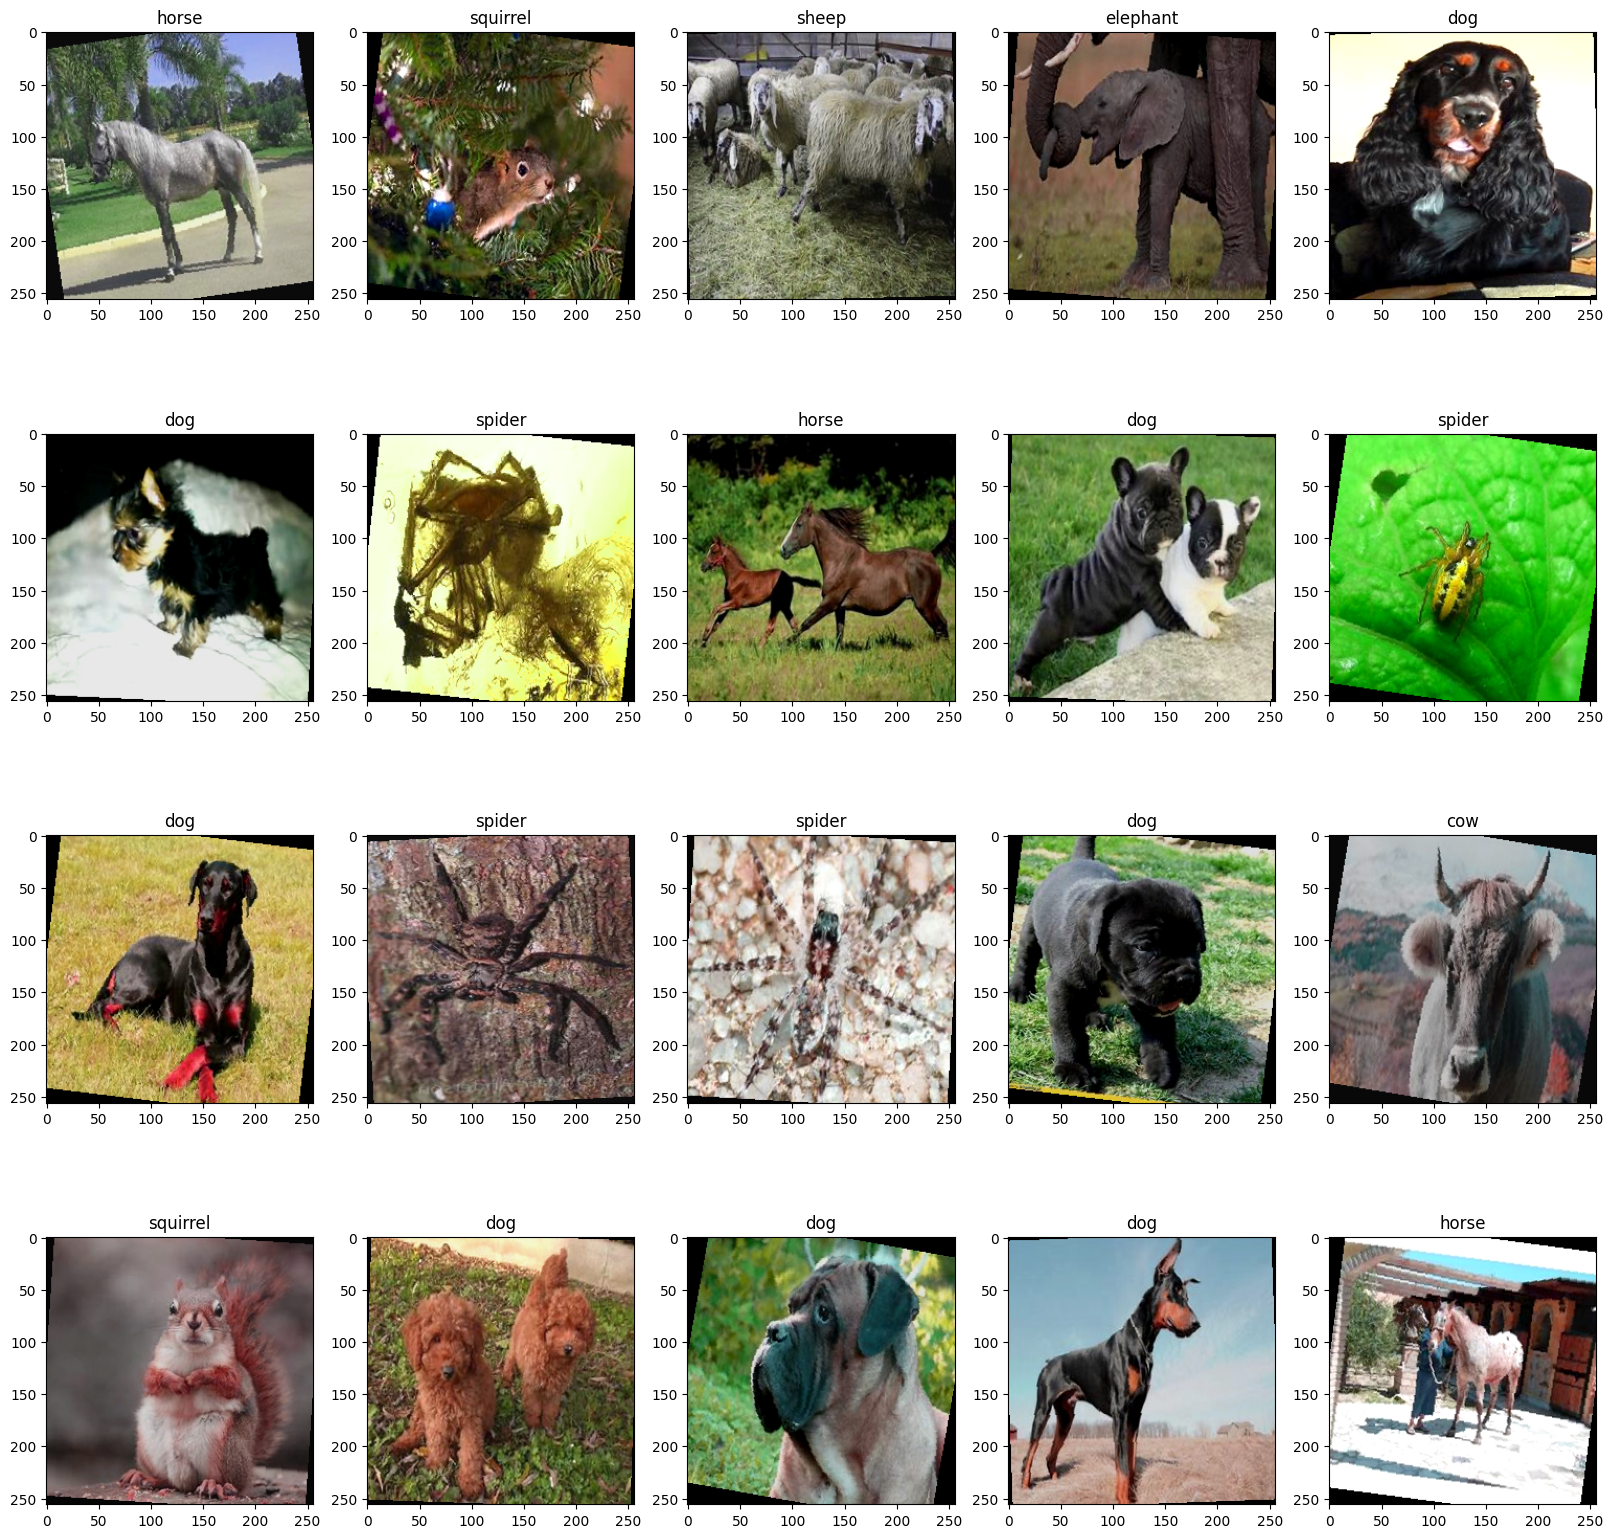

In [41]:
import math

number_of_images = 20  
images_per_row = 5  

data_iter = iter(train_ds)
samples = [next(data_iter) for _ in range(number_of_images)]

rows = math.ceil(number_of_images / images_per_row) 
plt.figure(figsize=(20, 5 * rows)) 

for i, (image, label) in enumerate(samples):
    plt.subplot(rows, images_per_row, i + 1)  
    imshow(image)
    class_name = full_dataset.classes[label]
    plt.title(translate_class(class_name))

plt.show()

Class dog: 4862 images
Class horse: 2620 images
Class elephant: 1445 images
Class butterfly: 2112 images
Class chicken: 3098 images
Class cat: 1668 images
Class cow: 1865 images
Class sheep: 1815 images
Class spider: 4821 images
Class squirrel: 1858 images


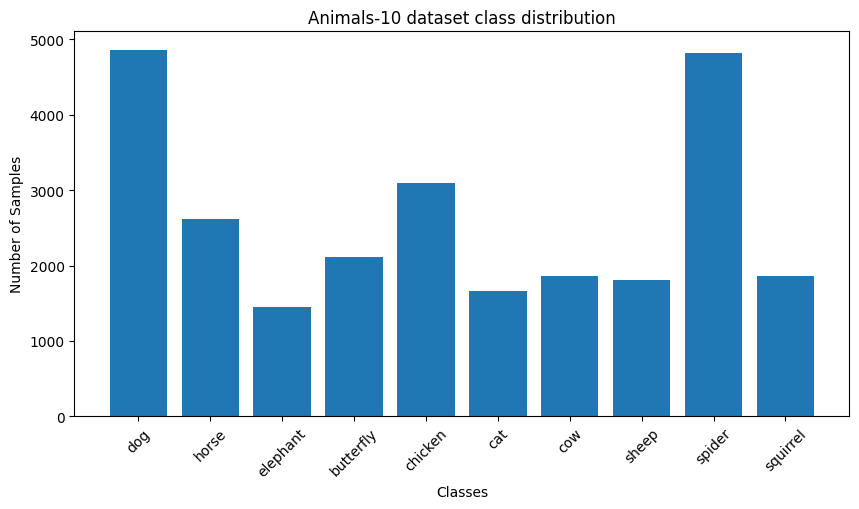

In [42]:
def show_class_distribution(dataset, bar_title):
    class_count = defaultdict(int)
    for _, label in full_dataset:
        class_count[label] += 1
        
    class_names = dataset.classes     
    num_classes = len(class_names)
    translated_class_names = [translate_class(class_name) for class_name in class_names]
    
    for i, class_name in enumerate(translated_class_names):
        print(f'Class {class_name}: {class_count[i]} images')
    
    plt.figure(figsize=(10, 5))
    plt.bar(translated_class_names, [class_count[i] for i in range(num_classes)])
    plt.xlabel('Classes')
    plt.ylabel('Number of Samples')
    plt.title(bar_title)
    plt.xticks(rotation=45)
    
    plt.show()
    
    
show_class_distribution(full_dataset, 'Animals-10 dataset class distribution')

The Animals-10 dataset is not balanced. Some classes have more images than others

***Identifying noisy data***

During quick manual analysis, there were found some invalid data in the dataset. For example, in the class of squirrels and elephants, there were images of other animals; in dog, cow and horse classes, there were random images without animals there etc. 

Those images were removed from the dataset or moved to the correct class.